# 2021 빅콘 데이터분석분야 챔피언리그 수산Biz 수산물 수입가격 예측 프로젝트

Renewal: 2021-09-14

최신화 내용:
> 범주별 fbProphet 적용, 다차원 시계열 분석
- add regressor 문제 encoding 함수 생성으로 해결
- <제조국: 중국, 수출국: 중국, 수입용도: 판매용, 수입형태: 냉동>의 경우를 우선적으로 예시로 잡아 모델적용

> 범주별 모델생성, 분석진행
- 자율평가 dataset과의 비교를 위해 데이터 전처리 후 merge

Made by: 안 동 근

In [61]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

import datetime
import warnings
warnings.filterwarnings("ignore")

In [62]:
train_data=pd.read_excel("train_data.xlsx")
print(train_data.shape)
train_data.head(10)

(42073, 10)


,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE
0,2015-12-28,수산물,아르헨티나,아르헨티나,판매용,갑각류,새우,아르헨티나붉은새우,냉동,7.480000
1,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,냉동,2.920000
2,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,"냉동,절단",3.356352
3,2015-12-28,수산물,칠레,칠레,판매용,패류 멍게류,해삼,해삼,"건조,자숙",18.260870
4,2015-12-28,수산물,중국,중국,판매용,어류,서대 박대 페루다,서대,냉동,4.791340
5,2015-12-28,수산물,중국,중국,판매용,어류,복어,은밀복,냉동,2.167951
6,2015-12-28,수산물,중국,중국,판매용,어류,옥돔,옥돔,냉동,5.145111
7,2015-12-28,수산물,중국,중국,판매용,어류,복어,까치복,냉동,4.265697
8,2015-12-28,수산물,중국,중국,판매용,갑각류,새우,흰다리새우,"냉동,살,자숙",7.202863
9,2015-12-28,수산물,중국,중국,판매용,갑각류,새우,흰다리새우,"냉동,살",6.972132


In [63]:
# 필요한 col만 가져온다
train_data=train_data.loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_NAME', 'P_IMPORT_TYPE', 'P_PRICE']]

In [64]:
# 상세어종이 오징어, 연어, 흰다리새우 인경우로만 dataframe 생성
df1=train_data[train_data.P_NAME=='오징어'].loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE', 'P_PRICE']]
df2=train_data[train_data.P_NAME=='연어'].loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE', 'P_PRICE']]
df3=train_data[train_data.P_NAME=='흰다리새우'].loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE', 'P_PRICE']]

In [65]:
# P_NAME=오징어 df의 인덱스 수정 (Label Encoding전 전처리)
df1.reset_index(inplace=True)
df1.drop(columns='index', inplace=True)
print(df1.shape)
df1.head(10)

(2150, 6)


,REG_DATE,CTRY_1,CTRY_2,P_PURPOSE,P_IMPORT_TYPE,P_PRICE
0,2015-12-28,대만,대만,판매용,"냉동,동체",1.989999
1,2015-12-28,중국,중국,판매용,"냉동,동체",0.793729
2,2015-12-28,페루,페루,판매용,"냉동,다리",1.233434
3,2015-12-28,페루,페루,판매용,"냉동,동체,자숙",5.481140
4,2015-12-28,칠레,칠레,판매용,"냉동,다리",0.968083
5,2015-12-28,칠레,칠레,판매용,"냉동,지느러미",0.762758
6,2015-12-28,칠레,칠레,판매용,"냉동,동체",0.962386
7,2016-01-04,칠레,칠레,판매용,"냉동,다리",0.945644
8,2016-01-04,페루,페루,판매용,"냉동,지느러미",0.600000
9,2016-01-04,페루,페루,자사제품제조용,"냉동,동체,자숙",3.716541


### Label Encoding

In [66]:
train=pd.DataFrame()
train['REG_DATE']=df1['REG_DATE']

for i in df1.columns[1:5]:          # Train Data Set : Label Encoding of category of column indices
    item_label=list(train_data[i])
    encoder = LabelEncoder()
    encoder.fit(item_label)
    digit_label = encoder.transform(item_label)
    
    globals()['{}_decoded'.format(i)]=[]
    for j in item_label:
        if j not in globals()['{}_decoded'.format(i)]:
            globals()['{}_decoded'.format(i)].append(j)
        
    globals()['{}_encoded'.format(i)]=[]
    for j in digit_label:
        if j not in globals()['{}_encoded'.format(i)]:
            globals()['{}_encoded'.format(i)].append(j)

    print(i, 'Label Encoding 결과 최대 digit:', digit_label.max(), '\n')
    print('*'*50)
    train[i]=pd.Series(digit_label)
    
train['P_PRICE']=df1['P_PRICE']

CTRY_1 Label Encoding 결과 최대 digit: 86 

**************************************************
CTRY_2 Label Encoding 결과 최대 digit: 87 

**************************************************
P_PURPOSE Label Encoding 결과 최대 digit: 4 

**************************************************
P_IMPORT_TYPE Label Encoding 결과 최대 digit: 77 

**************************************************


- 아래와 같은 인코딩 내용 저장을 통해 성능평가와 예측결과 도출에서 수월할 수 있게한다.

In [67]:
CTRY_1_decoded.index('중국')

3

In [68]:
CTRY_1_encoded[3]

65

In [69]:
len(CTRY_1_encoded), len(CTRY_1_decoded), len(CTRY_2_encoded), len(CTRY_2_decoded), len(P_PURPOSE_encoded), len(P_PURPOSE_decoded), len(P_IMPORT_TYPE_encoded), len(P_IMPORT_TYPE_decoded)

(87, 87, 88, 88, 5, 5, 78, 78)

- 위와 같은 방식을 함수로 생성

In [70]:
def encoding_to_num():
    x1=input('제조국을 입력하세요: ')
    y1=CTRY_1_encoded[CTRY_1_decoded.index(x1)]
    
    x2=input('수출국을 입력하세요: ')
    y2=CTRY_2_encoded[CTRY_2_decoded.index(x2)]
    
    x3=input('수입용도를 입력하세요: ')
    y3=P_PURPOSE_encoded[P_PURPOSE_decoded.index(x3)]
    
    x4=input('수입형태를 입력하세요: ')
    y4=P_IMPORT_TYPE_encoded[P_IMPORT_TYPE_decoded.index(x4)]
    
    result=[y1,y2,y3,y4]
    print('\n인코딩 결과 => 제조국:{} -> {}, 수출국:{} -> {}, 수입용도:{} -> {}, 수입형태:{} -> {}'.format(x1,y1,x2,y2,x3,y3,x4,y4))
    return result

In [71]:
option=encoding_to_num()

제조국을 입력하세요: 중국
수출국을 입력하세요: 중국
수입용도를 입력하세요: 판매용
수입형태를 입력하세요: 냉동

인코딩 결과 => 제조국:중국 -> 65, 수출국:중국 -> 64, 수입용도:판매용 -> 3, 수입형태:냉동 -> 8


In [72]:
# option = [65, 64, 3, 8]
# 제조국:중국, 수출국:중국, 수입용도:판매용, 수입형태:냉동의 데이터 옵션이 저장되어있다.

In [129]:
df=train.loc[:, ['REG_DATE', 'P_PRICE']]
df.rename(columns={'REG_DATE':'ds','P_PRICE':'y'}, inplace=True)

df['add1']=train['CTRY_1']
df['add2']=train['CTRY_2']
df['add3']=train['P_PURPOSE']
df['add4']=train['P_IMPORT_TYPE']

In [130]:
m = Prophet()

m.add_regressor('add1')
m.add_regressor('add2')
m.add_regressor('add3')
m.add_regressor('add4')

m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


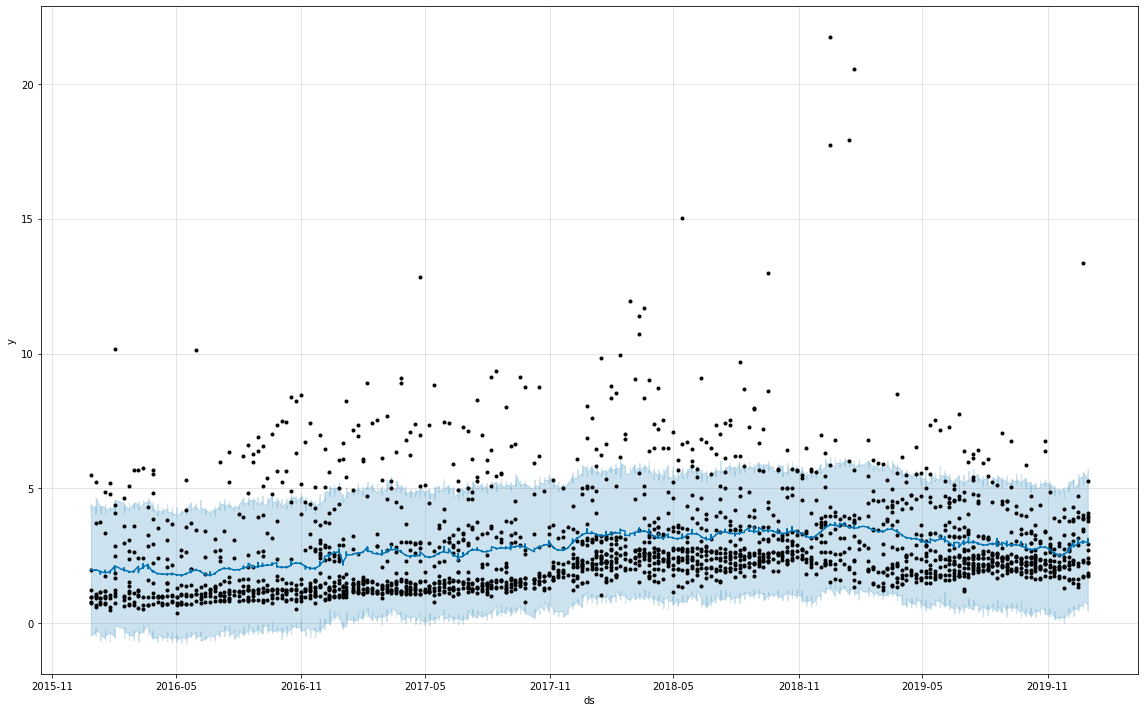

In [132]:
forecast=m.predict(df.drop(columns='y'))
fig1=m.plot(forecast, figsize=(16,10))

## 주(Week) 단위로 Future Dataframe 생성

In [133]:
future = m.make_future_dataframe(periods=52, freq='w')
# periods=52 - 자율평가제이터 기간까지 나옴
# periods=78 - 제출용 평가데이터기간 까지 나옴

In [134]:
future += datetime.timedelta(days=1)
future.tail()

,ds
255,2020-11-30
256,2020-12-07
257,2020-12-14
258,2020-12-21
259,2020-12-28


In [135]:
# add regressor to future dataframe(apply option)
j=1
for i in option:
    future['add'+str(j)]=i
    j+=1

In [136]:
future.tail()

,ds,add1,add2,add3,add4
255,2020-11-30,65,64,3,8
256,2020-12-07,65,64,3,8
257,2020-12-14,65,64,3,8
258,2020-12-21,65,64,3,8
259,2020-12-28,65,64,3,8


In [137]:
forecast=m.predict(future)

In [138]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
255,2020-11-30,2.102360,-0.410523,4.173087,1.993038,2.218148,-0.048387,-0.048387,-0.048387,0.04109,...,-0.019574,-0.019574,-0.019574,-0.114199,-0.114199,-0.114199,0.0,0.0,0.0,1.950427
256,2020-12-07,2.088982,-0.320026,4.345883,1.975953,2.208692,-0.048387,-0.048387,-0.048387,0.04109,...,-0.019574,-0.019574,-0.019574,0.060271,0.060271,0.060271,0.0,0.0,0.0,2.111519
257,2020-12-14,2.075604,-0.149426,4.567598,1.958628,2.198734,-0.048387,-0.048387,-0.048387,0.04109,...,-0.019574,-0.019574,-0.019574,0.208100,0.208100,0.208100,0.0,0.0,0.0,2.245970
258,2020-12-21,2.062226,-0.037981,4.768872,1.941273,2.188777,-0.048387,-0.048387,-0.048387,0.04109,...,-0.019574,-0.019574,-0.019574,0.293999,0.293999,0.293999,0.0,0.0,0.0,2.318491
259,2020-12-28,2.048848,-0.209063,4.627083,1.924063,2.178819,-0.048387,-0.048387,-0.048387,0.04109,...,-0.019574,-0.019574,-0.019574,0.308164,0.308164,0.308164,0.0,0.0,0.0,2.319277


In [139]:
forecast[['ds', 'yhat']].tail()

,ds,yhat
255,2020-11-30,1.950427
256,2020-12-07,2.111519
257,2020-12-14,2.245970
258,2020-12-21,2.318491
259,2020-12-28,2.319277


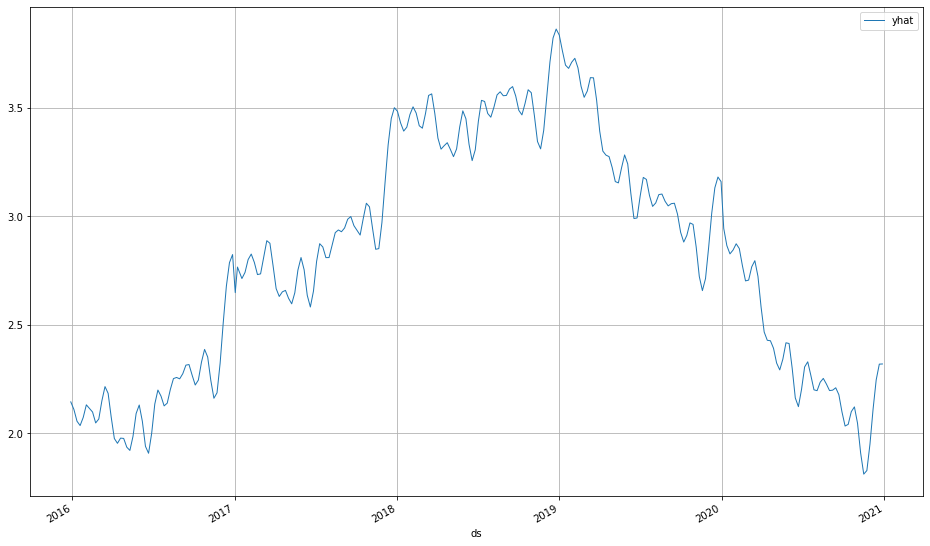

In [140]:
# INITIALIZE FIG DIMENSION AND AXES OBJECTS
fig, axs = plt.subplots(figsize=(16,10))

# ASSIGN AXES OBJECTS ACCORDINGLY
forecast.plot(ax=axs, x='ds', y='yhat', grid=True, label="yhat", linewidth=1)

plt.show()

## 자율평가데이터 불러오기

In [141]:
valid=pd.read_excel('2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_자율평가데이터.xlsx')
print(valid.shape)
valid.head()

(9479, 10)


,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE
0,2020-01-06,수산물,호주,일본,판매용,어류,참치 새치류,남방참다랑어,"냉동,목살",4.883410
1,2020-01-06,수산물,칠레,일본,자사제품제조용,어류,연어,은연어,냉동,5.391782
2,2020-01-06,수산물,중국,중국,판매용,어류,도다리,강도다리,활,6.764961
3,2020-01-06,수산물,중국,중국,판매용,어류,복어,자주복,활,18.499875
4,2020-01-06,수산물,중국,중국,판매용,어류,복어,은밀복,냉동,3.071645


In [142]:
valid1=valid[valid.P_NAME=='오징어'].loc[:,['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'P_IMPORT_TYPE', 'P_PRICE']]
print(valid1.shape)
valid1.head()

(621, 6)


,REG_DATE,CTRY_1,CTRY_2,P_PURPOSE,P_IMPORT_TYPE,P_PRICE
15,2020-01-06,중국,중국,판매용,"냉동,슬라이스(S)",2.706303
16,2020-01-06,중국,중국,판매용,"냉동,다리",1.940000
39,2020-01-06,페루,칠레,판매용,"냉동,동체",2.195883
40,2020-01-06,페루,칠레,판매용,"냉동,지느러미",1.922647
41,2020-01-06,페루,페루,판매용,"냉동,다리",2.855495


In [143]:
sample=valid1[(valid1['CTRY_1']=='중국') & (valid1['CTRY_2']=='중국') & (valid1['P_PURPOSE']=='판매용') & (valid1['P_IMPORT_TYPE']=='냉동')]
sample.reset_index(inplace=True)
sample.drop(columns='index', inplace=True)
print(sample.shape)
sample.tail()

(51, 6)


,REG_DATE,CTRY_1,CTRY_2,P_PURPOSE,P_IMPORT_TYPE,P_PRICE
46,2020-11-30,중국,중국,판매용,냉동,3.255586
47,2020-12-07,중국,중국,판매용,냉동,3.185604
48,2020-12-14,중국,중국,판매용,냉동,3.152568
49,2020-12-21,중국,중국,판매용,냉동,3.444083
50,2020-12-28,중국,중국,판매용,냉동,3.150000


In [145]:
forecast[['ds', 'yhat']].tail(10)

,ds,yhat
250,2020-10-26,2.121627
251,2020-11-02,2.046234
252,2020-11-09,1.909296
253,2020-11-16,1.811951
254,2020-11-23,1.828440
255,2020-11-30,1.950427
256,2020-12-07,2.111519
257,2020-12-14,2.245970
258,2020-12-21,2.318491
259,2020-12-28,2.319277


In [146]:
forecast=forecast[['ds','yhat']]
forecast.rename(columns={'ds':'REG_DATE', 'yhat':'PRED_PRICE'}, inplace=True)

In [147]:
# 두개의 Dataframe을 공통되는 REG_DATE에 대해서만 병합. 나머지 row는 drop

In [148]:
print(sample[['REG_DATE','P_PRICE']].shape)
sample[['REG_DATE','P_PRICE']].head(10)

(51, 2)


,REG_DATE,P_PRICE
0,2020-01-06,4.347919
1,2020-01-13,4.161563
2,2020-01-20,4.123939
3,2020-01-27,3.227511
4,2020-02-03,1.117007
5,2020-02-17,4.388564
6,2020-02-24,3.149709
7,2020-03-02,3.071110
8,2020-03-09,2.656746
9,2020-03-16,3.512462


In [160]:
pred_sample=forecast.tail(52)
pred_sample.reset_index(inplace=True)
pred_sample.drop(columns='index', inplace=True)
print(pred_sample.shape)
pred_sample.head(10)

(52, 2)


,REG_DATE,PRED_PRICE
0,2020-01-06,2.943331
1,2020-01-13,2.864439
2,2020-01-20,2.826242
3,2020-01-27,2.843962
4,2020-02-03,2.872782
5,2020-02-10,2.850870
6,2020-02-17,2.772092
7,2020-02-24,2.701824
8,2020-03-02,2.705536
9,2020-03-09,2.766769


In [164]:
pd.merge(sample[['REG_DATE','P_PRICE']], pred_sample, on='REG_DATE')

,REG_DATE,P_PRICE,PRED_PRICE
0,2020-01-06,4.347919,2.943331
1,2020-01-13,4.161563,2.864439
2,2020-01-20,4.123939,2.826242
3,2020-01-27,3.227511,2.843962
4,2020-02-03,1.117007,2.872782
5,2020-02-17,4.388564,2.772092
6,2020-02-24,3.149709,2.701824
7,2020-03-02,3.071110,2.705536
8,2020-03-09,2.656746,2.766769
9,2020-03-16,3.512462,2.794994


# What is Next?

In [236]:
from sklearn.metrics import mean_squared_error

성능평가>>

Futrue에 대한 시각화>>